# Beneficiários

In [1]:
import os
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from io import BytesIO
from datetime import datetime
from collections import defaultdict

### Códigos ANS (RI Hapvida)

In [3]:
# donwload dos códigos ANS de Hapvida e GNDI

RI_URL = 'https://api.mziq.com/mzfilemanager/v2/d/6bbd1770-f9f4-44e8-a1b1-d26b7585eec1/6d20a378-c816-6a0a-ad88-d557761215bd?origin=1'

def ans_codes(url, empresa):
    response = requests.get(url)
    content = response.content

    if empresa == 'HAPVIDA':
        df = pd.read_excel(BytesIO(content), sheet_name='Códigos ANS_ANS Code', skiprows=1, nrows=28, usecols=[0,1,2,3,4])
        df.columns = ['CD_ANS', 'EMPRESA', 'GRUPO', 'ASSINATURA', 'FECHAMENTO']

    elif empresa == 'GNDI':
        df = pd.read_excel(BytesIO(content), sheet_name='Códigos ANS_ANS Code', skiprows=1, nrows=33, usecols=[6, 7, 8, 9])
        df.columns = ['CD_ANS', 'EMPRESA', 'ASSINATURA', 'FECHAMENTO']

    else:
        raise ValueError("Invalid empresa value. Must be 'HAPVIDA' or 'GNDI'.")

    return df

In [4]:
# download hapvida ANS codes

hapvida = ans_codes(RI_URL, 'HAPVIDA')
hapvida_codes = hapvida['CD_ANS'].astype('int32')

hapvida_codes.shape


(28,)

In [5]:
intermedica = ans_codes(RI_URL, 'GNDI')

intermedica_codes = intermedica['CD_ANS'].dropna()
intermedica_codes = intermedica_codes.iloc[:-1].tolist() + intermedica_codes.iloc[-1].split('/')
intermedica_codes = pd.Series(intermedica_codes).astype('int32')

# fix intermedica codes

intermedica_codes.loc[intermedica_codes == 33925] = 339245
intermedica_codes.loc[intermedica_codes == 34527] = 345270
intermedica_codes.loc[intermedica_codes == 32468] = 324698
intermedica_codes.loc[intermedica_codes == 30912] = 309192
intermedica_codes.loc[intermedica_codes == 32507] = 325074
intermedica_codes.loc[intermedica_codes == 35901] = 359017

intermedica_codes.shape


(20,)

In [6]:
# combine all closings codes

combined_codes = pd.concat([hapvida_codes, intermedica_codes], ignore_index=True)

# combined_codes = pd.concat([combined_codes, pd.Series([335614])], ignore_index=True)


In [7]:
combined_codes.unique()

array([368253, 415847, 351091, 302091, 323811, 309338, 339539, 333328,
       365319, 405604, 411124, 417181, 413127, 416614, 415812, 401196,
       410632, 414450, 414131, 360767, 413275, 402851, 373141, 410047,
       348805, 346471, 417823, 350249, 359017, 339245, 345270, 324698,
       309192, 325074, 368849, 351563, 349755, 344362, 340782, 414298,
       349194, 309699, 343013, 402966, 348520, 306649, 354554, 361852],
      dtype=int32)

In [8]:
bradesco = [5711]
sulamerica = [6246, 477, 350141]
amil = [326305, 326500]
cassi = [346659]
unimed = [339679, 343889, 393321, 701, 352501] 

In [19]:
ans_codes = {'Bradesco': bradesco, 'SulAmérica': sulamerica, 'Amil': amil, 'Cassi': cassi, 'Unimed': unimed, 'Hapvida': hapvida_codes, 'Intermédica': intermedica_codes}

df_codes = pd.DataFrame(list(ans_codes.items()), columns=['OPERADORA', 'CD_ANS'])

df_codes = df_codes.explode('CD_ANS').reset_index(drop=True)

df_codes.head()

,OPERADORA,CD_ANS
0,Bradesco,5711
1,SulAmérica,6246
2,SulAmérica,477
3,SulAmérica,350141
4,Amil,326305


In [ ]:
df_codes.to_csv('data/dados_agregados/codigo_ans.csv', index=False)

### Beneficiários

In [14]:
df_list = []

types = defaultdict(lambda: 'int32', {'SG_UF': 'category', 'DE_FAIXA_ETARIA': 'category'})

for file in os.listdir('data/beneficiarios'):
    temp_df = pd.read_csv(f'data/beneficiarios/{file}', usecols=['CD_OPERADORA', 'DE_FAIXA_ETARIA', 'SG_UF', 'COBERTURA_ASSIST_PLAN', 'QT_BENEFICIARIO_ATIVO'], dtype=types)
    
    temp_df = temp_df.loc[temp_df['COBERTURA_ASSIST_PLAN'] == 1, :].copy()
    temp_df['ID'] = str(file)[:-4]
    
    grouped_data = temp_df.groupby(['ID', 'CD_OPERADORA', 'DE_FAIXA_ETARIA', 'SG_UF'], observed=False)['QT_BENEFICIARIO_ATIVO'].sum().reset_index()

    del temp_df

    df_list.append(grouped_data)

benef = pd.concat(df_list, ignore_index=True)

benef.head()

,ID,CD_OPERADORA,DE_FAIXA_ETARIA,SG_UF,QT_BENEFICIARIO_ATIVO
0,201803,27,00 a 05 anos,AC,0
1,201803,27,00 a 05 anos,AL,0
2,201803,27,00 a 05 anos,AM,0
3,201803,27,00 a 05 anos,AP,0
4,201803,27,00 a 05 anos,BA,0


In [15]:
benef = pd.concat(df_list, ignore_index=True).to_csv('data/dados_agregados/grouped_beneficiarios.csv', index=False)

### Market Share

In [22]:
dict = {}

for file in os.listdir('data/beneficiarios'):
    temp_df = pd.read_csv(f'data/beneficiarios/{file}', usecols=['CD_OPERADORA', 'COBERTURA_ASSIST_PLAN', 'QT_BENEFICIARIO_ATIVO'], dtype='int32')
    
    temp_df = temp_df.loc[temp_df['COBERTURA_ASSIST_PLAN'] == 1, :].copy()
    temp_df['OPERADORA'] = np.where(temp_df['CD_OPERADORA'].isin(combined_codes), 1, 0)
    
    grouped_data = temp_df.groupby('OPERADORA')['QT_BENEFICIARIO_ATIVO'].sum()
    percentage_data = grouped_data / grouped_data.sum() * 100

    del temp_df

    dict[str(file)[:-4]] = percentage_data[1]

dict

{'201803': 15.667173460967762,
 '202306': 17.483456024353757,
 '202003': 17.698233227867373,
 '201809': 16.093856368394828,
 '202112': 18.03911361670293,
 '202209': 17.98109351233897,
 '202109': 17.925631626317916,
 '201906': 16.80268122498746,
 '202203': 17.8563400227219,
 '201909': 17.148156907866703,
 '202009': 18.119537902392025,
 '202303': 17.75047254684394,
 '201912': 17.555267916894422,
 '201903': 16.404700506931864,
 '202103': 18.175856559971287,
 '201806': 15.982515176792916,
 '202106': 18.134371711919673,
 '202309': 17.32724788245964,
 '201812': 16.270645509698838,
 '202212': 17.799176937091673,
 '202206': 18.021714940993633,
 '202006': 17.720271674691908,
 '202012': 18.197871754884872}

In [24]:
mkt_share = pd.DataFrame(dict.items(), columns=['ID', 'MKT_SHARE'])

mkt_share['ID'] = mkt_share['ID'].apply(lambda x: datetime.strptime(x, "%Y%m"))
mkt_share = mkt_share.sort_values(by='ID').reset_index(drop=True)

mkt_share.head(10)

,ID,MKT_SHARE
0,2018-03-01,15.667173
1,2018-06-01,15.982515
2,2018-09-01,16.093856
3,2018-12-01,16.270646
4,2019-03-01,16.404701
5,2019-06-01,16.802681
6,2019-09-01,17.148157
7,2019-12-01,17.555268
8,2020-03-01,17.698233
9,2020-06-01,17.720272


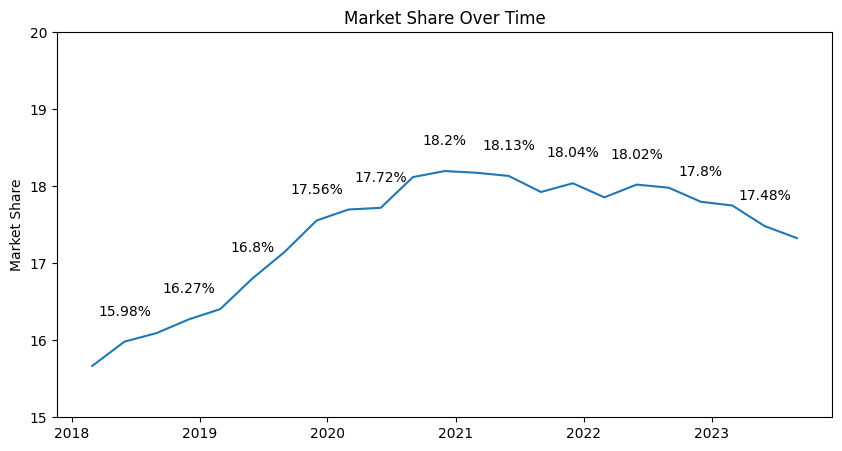

In [58]:
plt.figure(figsize=(10, 5))

sns.lineplot(data=mkt_share, x='ID', y='MKT_SHARE')

for x, y in zip(mkt_share['ID'], mkt_share['MKT_SHARE']):
    plt.text(x, y+0.3, str(round(y, 2)) + '%' if x.month % 6 == 0 else '', ha='center', va='bottom')

plt.xlabel('')
plt.ylabel('Market Share')
plt.ylim(15, 20)
plt.title('Market Share Over Time')
plt.show()


In [64]:
# número de beneficiários ativos e taxa de cobertura 9M2023

ben2023 = pd.read_csv('data/beneficiarios/202309.csv', usecols=['CD_OPERADORA', 'COBERTURA_ASSIST_PLAN', 'QT_BENEFICIARIO_ATIVO'], dtype='int32')

beneficiarios_ativos = ben2023.loc[ben2023['COBERTURA_ASSIST_PLAN'] == 1, :]['QT_BENEFICIARIO_ATIVO'].sum()

print(f"Número de beneficiários ativos: {beneficiarios_ativos/1000000:.1f} milhões")
print(f"Taxa de Cobertura: {beneficiarios_ativos / 203062512:.2%}")


Número de beneficiários ativos: 50.8 milhões
Taxa de Cobertura: 25.04%
          CD_OPERADORA  COBERTURA_ASSIST_PLAN  QT_BENEFICIARIO_ATIVO
3                 5711                      1                      1
59                5711                      1                      1
73                5711                      1                      1
83                5711                      1                      1
93                5711                      1                      1
...                ...                    ...                    ...
16702640          5711                      1                      1
16703268          5711                      1                      1
16703444          5711                      1                      1
16703720          5711                      1                      1
16703995          5711                      1                      1

[690732 rows x 3 columns]


### Market Share (Operadoras)

In [76]:
dict = {}

for file in os.listdir('data/beneficiarios'):
    temp_df = pd.read_csv(f'data/beneficiarios/{file}', usecols=['CD_OPERADORA', 'COBERTURA_ASSIST_PLAN', 'QT_BENEFICIARIO_ATIVO'], dtype='int32')
    
    temp_df = temp_df.loc[temp_df['COBERTURA_ASSIST_PLAN'] == 1, :].copy()
    temp_df['OPERADORA'] = np.where(temp_df['CD_OPERADORA'].isin(combined_codes), 'Hapvida', 
                            np.where(temp_df['CD_OPERADORA'].isin(bradesco), 'Bradesco',
                            np.where(temp_df['CD_OPERADORA'].isin(sulamerica), 'SulAmérica',
                            np.where(temp_df['CD_OPERADORA'].isin(amil), 'Amil',
                            np.where(temp_df['CD_OPERADORA'].isin(cassi), 'Cassi',
                            np.where(temp_df['CD_OPERADORA'].isin(unimed), 'Unimed', 'Outros'))))))

    temp_df['OPERADORA'] = temp_df['OPERADORA'].astype('category')
    
    grouped_data = temp_df.groupby('OPERADORA', observed=False)['QT_BENEFICIARIO_ATIVO'].sum()
    percentage_data = grouped_data / grouped_data.sum() * 100

    del temp_df

    dict[str(file)[:-4]] = percentage_data.to_dict()

dict

{'201803': {'Amil': 7.872375469705223,
  'Bradesco': 7.07529386421791,
  'Cassi': 1.479573983893639,
  'Hapvida': 15.667173460967762,
  'Outros': 54.22480791062449,
  'SulAmérica': 4.135972247545582,
  'Unimed': 9.544803063045386},
 '202306': {'Amil': 5.510909561835435,
  'Bradesco': 6.624936103353141,
  'Cassi': 1.1702295965438574,
  'Hapvida': 17.483456024353757,
  'Outros': 53.547172953988245,
  'SulAmérica': 4.665944927157376,
  'Unimed': 10.997350832768191},
 '202003': {'Amil': 6.634681566322455,
  'Bradesco': 7.047033899414425,
  'Cassi': 1.3848827458591455,
  'Hapvida': 17.698233227867373,
  'Outros': 52.55503811731499,
  'SulAmérica': 4.306279723961263,
  'Unimed': 10.373850719260345},
 '201809': {'Amil': 7.657110835786307,
  'Bradesco': 6.978080477642136,
  'Cassi': 1.4648661386009627,
  'Hapvida': 16.093856368394828,
  'Outros': 53.856664515184924,
  'SulAmérica': 4.157280924171213,
  'Unimed': 9.792140740219631},
 '202112': {'Amil': 6.1676258223138065,
  'Bradesco': 6.674082

In [80]:
share_operadoras = pd.DataFrame([(key, *key_pair) for key, value in dict.items() for key_pair in value.items()], columns=['ID', 'OPERADORA', 'MKT_SHARE'])

share_operadoras = share_operadoras.loc[share_operadoras['OPERADORA'] != 'Outros', :].copy()
share_operadoras['ID'] = share_operadoras['ID'].apply(lambda x: datetime.strptime(x, "%Y%m"))
share_operadoras = share_operadoras.sort_values(by='ID').reset_index(drop=True)

share_operadoras

,ID,OPERADORA,MKT_SHARE
0,2018-03-01,Amil,7.872375
1,2018-03-01,Bradesco,7.075294
2,2018-03-01,Cassi,1.479574
3,2018-03-01,Hapvida,15.667173
4,2018-03-01,SulAmérica,4.135972
...,...,...,...
133,2023-09-01,Hapvida,17.327248
134,2023-09-01,Bradesco,6.522741
135,2023-09-01,Amil,5.625219
136,2023-09-01,Unimed,10.948707


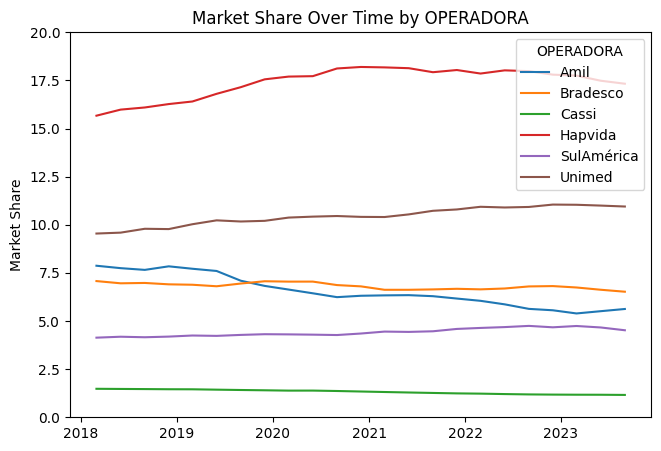

In [87]:
plt.figure(figsize=(7.5, 5))

sns.lineplot(data=share_operadoras, x='ID', y='MKT_SHARE', hue='OPERADORA')

plt.xlabel('')
plt.ylabel('Market Share')
plt.ylim(0, 20)
plt.title('Market Share Over Time by OPERADORA')
plt.legend(title='OPERADORA')
plt.show()
